### Maryum Tanvir — 22i-0751


# Pneumonia Detection from Chest X-Rays
### Convolutional Neural Network (CNN)-based Model  
Classifies chest X-ray images into:

- **NORMAL**
- **PNEUMONIA**



In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras #for DL 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2 
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau

## Dense: Every neuron in prev layer is connected to every neuron in the next layer
## Dropout is to prevent overfitting
## Batch Normalization: stablizing training
## ImageDataGenerator: Helps Augement images because data is imbalanced e.g zoom, flip, rotation etc



## Loading Dataset


In [2]:
labels = ["PNEUMONIA", "NORMAL"] 
image_resize_size = 150

def load_data(directory):
    data = []  # Each entry in data will be a pair: [image_array , label number]                        
    for label in labels:
        path = os.path.join(directory, label)
        class_num = labels.index(label)                                         # 0 for PNEUMONIA, 1 for NORMAL

        for img_name in os.listdir(path):   # This loops through each file (image) in the current label folder.
            try:
                if img_name.endswith('jpeg') or img_name.endswith('jpg'):
                    img_path = os.path.join(path, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)                # Load as grayscale as it is enough for medical images
                    img = cv2.resize(img, (image_resize_size, image_resize_size))   # Resize image Images can be different sizes,
                                                                                    # so we resize them to the same shape so that our model can process them easily.
                    data.append([img, class_num])
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")
    
    return data

In [3]:
train_data = load_data("chest_xray/train")
validation_data = load_data("chest_xray/val")
test_data = load_data("chest_xray/test")

print("Loaded train", len(train_data), "images")
print("Loaded validation", len(validation_data), "images")
print("Loaded test", len(test_data), "images")




Loaded train 5216 images
Loaded validation 16 images
Loaded test 624 images


## Visualizing the loaded data

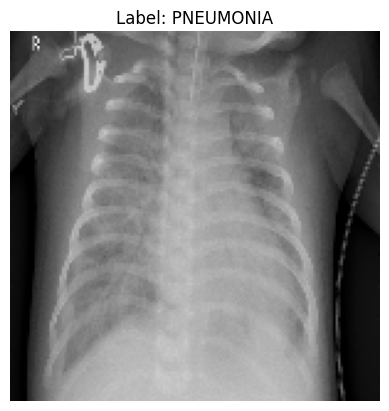

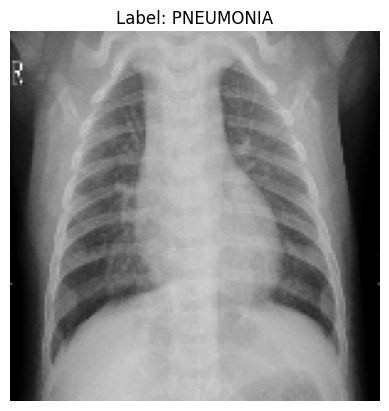

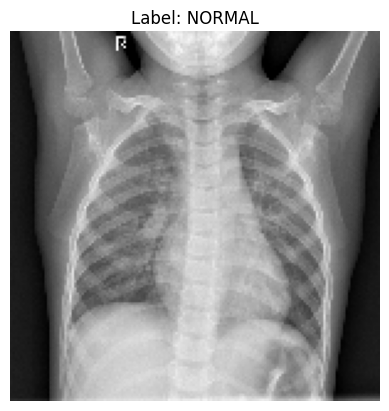

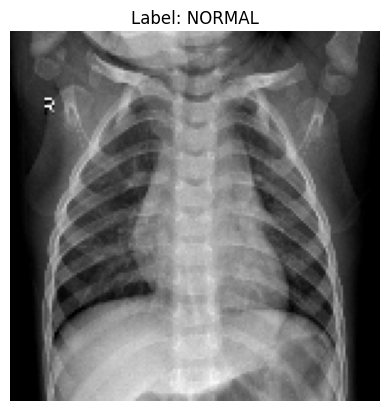

In [4]:
pneumonia_count = 0
normal_count = 0

for img, label in train_data:
    if label == 0 and pneumonia_count < 2:
        plt.imshow(img, cmap='gray')
        plt.title("Label: PNEUMONIA")
        plt.axis('off')
        plt.show()
        pneumonia_count += 1

    elif label == 1 and normal_count < 2:
        plt.imshow(img, cmap='gray')
        plt.title("Label: NORMAL")
        plt.axis('off')
        plt.show()
        normal_count += 1

    # Break the loop after showing 3 of each
    if pneumonia_count == 3 and normal_count == 3:
        break

###  Understanding Data Distribution

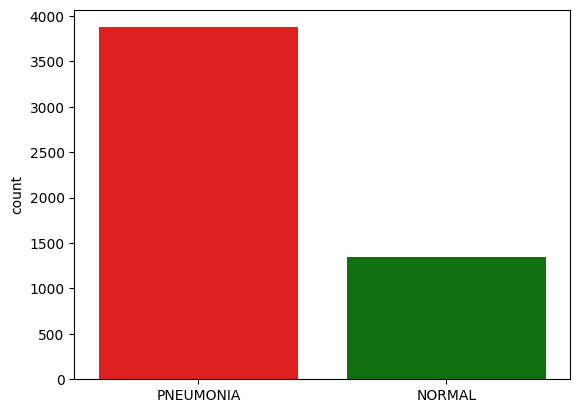

In [5]:
image_label = []

for train in train_data:
    if(train[1] == 0):
        image_label.append('PNEUMONIA')
    else:
        image_label.append("NORMAL")
        
sns.countplot(x=image_label, palette=['red', 'green'], hue = image_label, legend=False )
plt.show()

## Preprocessing the Data for Model Training

In [6]:
X_train = []
Y_train = []

X_val = []
Y_val = []

X_test = []
Y_test = []

for img, label in train_data:
    X_train.append(img)
    Y_train.append(label)
    
for img, label in validation_data:
    X_val.append(img)
    Y_val.append(label)

for img, label in test_data:
    X_test.append(img)
    Y_test.append(label)
    


### Why Resize Images?

Images in real-world datasets have different sizes, but deep learning models require all inputs to have the same shape. We resize all images (e.g., to 150x150 pixels) to ensure consistency in model input and to allow efficient training.

---

### Why Convert to NumPy Arrays?

Deep learning models expect the input data to be in a structured numerical format. Converting lists of images and labels to NumPy arrays allows:
- Faster numerical operations
- Easy reshaping and normalization
- Compatibility with model input format `(number of images, height, width, channels)`

---

### Why Normalize Pixel Values by Dividing by 255?

Grayscale image pixels range from 0 to 255. Dividing by 255 scales these values to the range [0, 1]. This normalization helps:
- Improve training stability
- Speed up learning
- Ensure consistent input values across the dataset


In [7]:
# Convert image lists to numpy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)


# Diving by 255 because that is the largest pixel value
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

### Reshaping Images for CNN Input

CNNs require input in a 4D shape:  
`(number of samples, image height, image width, number of channels)`

We use `.reshape(-1, image_resize_size, image_resize_size, 1)` to prepare our image data accordingly.

#### Explanation of Each Parameter:

| Value                  | Meaning                          | Why We Use It                                 |
|------------------------|----------------------------------|-----------------------------------------------|
| `-1`                   | Automatically calculates the number of images (samples) | Let NumPy infer how many total images there are |
| `image_resize_size`    | The height of each image (e.g., 150)  | Matches the size we resized the images to        |
| `image_resize_size`    | The width of each image (e.g., 150)   | Same as the height in our case                   |
| `1`                    | Number of color channels             | 1 because we're using grayscale images           |


In [8]:
# .reshape() is a NumPy function that changes the shape or dimensions of an array without changing its data.
X_train = X_train.reshape(-1, image_resize_size, image_resize_size, 1)
X_val = X_val.reshape(-1, image_resize_size, image_resize_size, 1)
X_test = X_test.reshape(-1, image_resize_size, image_resize_size, 1)

# Print shapes
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)


X_train shape: (5216, 150, 150, 1)
X_val shape: (16, 150, 150, 1)
X_test shape: (624, 150, 150, 1)


### Why Use ImageDataGenerator for Data Augmentation?

In our dataset, the number of pneumonia and normal images is imbalanced. If we train a model on this data directly, it may become biased by predicting the majority class more often which is pneumonia in our case.

To address this, we use **data augmentation**, which artificially increases the size and diversity of the training set by applying random transformations to the images.

This helps in two ways:
- **Balances the dataset** by generating more variations of the minority class (e.g., NORMAL)
- **Improves generalization** so the model performs better on unseen data

We use TensorFlow's `ImageDataGenerator` to apply transformations like:
- Rotation
- Shifting
- Zooming
- Horizontal flipping

These variations simulate real world differences in X-ray positioning and patient posture without needing more actual images.


In [9]:
data_generator = ImageDataGenerator(
    featurewise_center=False,         # Do not center the entire dataset
    samplewise_center=False,          # Do not center each image individually
    featurewise_std_normalization=False,  # Do not normalize across the dataset
    samplewise_std_normalization=False,   # Do not normalize each image individually
    rotation_range=15,               # Randomly rotate images by 0 to 15 degrees
    width_shift_range=0.1,           # Shift images horizontally by up to 10%
    height_shift_range=0.1,          # Shift images vertically by up to 10%
    shear_range=0.1,                 # Shear transformation
    zoom_range=0.1,                  # Random zoom
    horizontal_flip=True,            # Randomly flip images horizontally
    vertical_flip = False,
    fill_mode='nearest'              # Fill pixels after transformation
)

data_generator.fit(X_train)

## Creating and Training the Model


### Model Overview

We use a sequential series of convolutional blocks followed by dense layers:

- Input: 150x150 grayscale images (shape = (150, 150, 1))
- Conv layers: 5 blocks with increasing filters (32 -> 256)
- Activation: ReLU for hidden layers, Sigmoid for output
- Pooling: MaxPooling after each conv block
- Regularization: Dropout + BatchNormalization
- Output: 1 neuron (binary classification)




In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

# Input layer
input_layer = Input(shape=(150, 150, 1))

# Conv Block 
x = Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)

# Conv Block 
x = Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)

# Conv Block 
x = Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)

# Conv Block 
x = Conv2D(128, (3, 3), strides=1, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)

# Conv Block 
x = Conv2D(256, (3, 3), strides=1, padding='same', activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)

# Dense layers
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Build the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [11]:
reduce_learning_rate_on_plateau = ReduceLROnPlateau(monitor='val_accuracy', patience =2, verbose= 1, factor = 0.3, min_lr= 0.0001)

In [ ]:
history = model.fit(
    data_generator.flow(X_train, Y_train, batch_size=32),  # Apply augmentation to training data
    epochs=12,
    validation_data=(X_val, Y_val),  
    callbacks=[reduce_learning_rate_on_plateau]
)

c:\Users\Maryum\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 126s 738ms/step - accuracy: 0.8362 - loss: 0.5911 - val_accuracy: 0.5000 - val_loss: 9.4233 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.9146 - loss: 0.2040 - val_accuracy: 0.5000 - val_loss: 13.6187 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9423 - loss: 0.1513
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.9423 - loss: 0.1513 - val_accuracy: 0.5000 - val_loss: 7.5395 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 144s 880ms/step - accuracy: 0.9541 - loss: 0.1238 - val_accuracy: 0.6875 - val_loss: 0.7344 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 739ms/step - accuracy: 0.9631 - loss: 0.1036 - val_accuracy: 0.5625 - val_loss: 0.9709 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0

In [ ]:

model.save('my_model.keras')

## Performance Evaluation of the Model

In [14]:
from tensorflow import keras
model = keras.models.load_model('my_model.keras')


print( f"Loss of model = {model.evaluate(X_test,Y_test)[0]*100}")
print( f"Accuracy of model = {model.evaluate(X_test,Y_test)[1]*100}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - accuracy: 0.9450 - loss: 0.1448
Loss of model = 35.676753520965576
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9450 - loss: 0.1448
Accuracy of model = 87.9807710647583


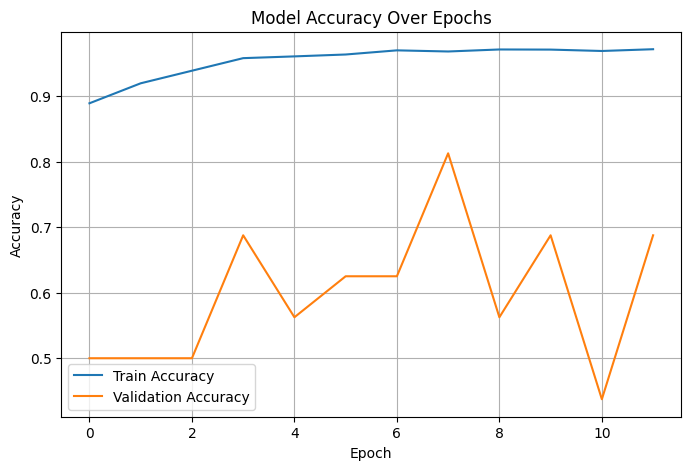

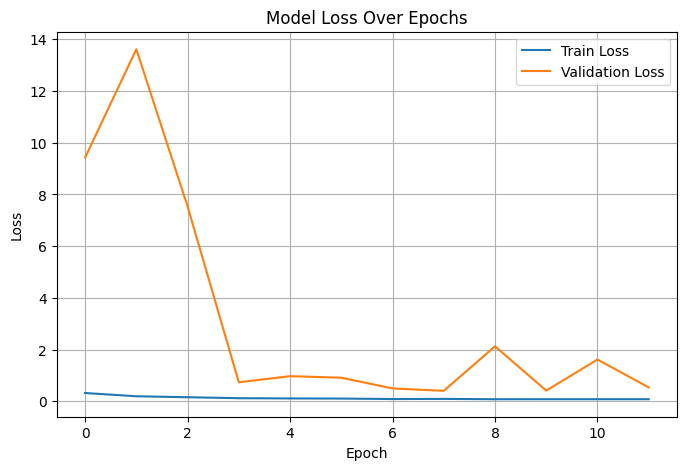

In [15]:
# Accuracy graph
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss graph
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
predictions = (model.predict(X_test) > 0.5).astype('int32')


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step


In [17]:
print(classification_report(Y_test, predictions,target_names=['PNEUMONIA (Class = 0)', "NORMAL (Class = 1)"]))

                       precision    recall  f1-score   support

PNEUMONIA (Class = 0)       0.86      0.97      0.91       390
   NORMAL (Class = 1)       0.94      0.73      0.82       234

             accuracy                           0.88       624
            macro avg       0.90      0.85      0.86       624
         weighted avg       0.89      0.88      0.88       624



[[375  15]
 [173  61]]


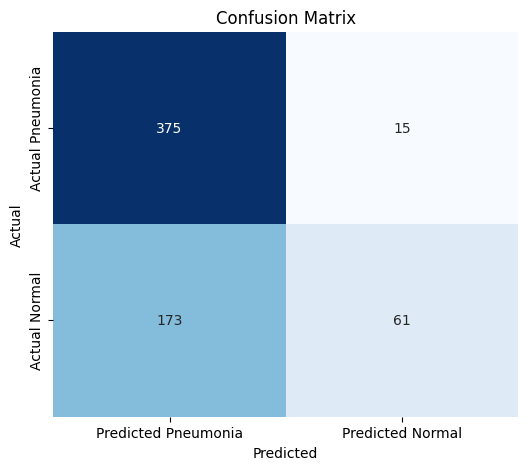

In [38]:
c_matrix = confusion_matrix(Y_test,predictions)
print(c_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Pneumonia', 'Predicted Normal'],
            yticklabels=['Actual Pneumonia', 'Actual Normal'])

plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Interpretability (Grad CAM)

Grad-CAM (Gradient-weighted Class Activation Mapping) highlights the areas in an image that most influenced the model's prediction.

#### What the Colors Represent:
- Red/Yellow: Strong influence on the model's decision
- Green: Moderate influence
- Blue: Little to no influence

#### Interpretation:
The highlighted regions in the heatmap focus on the lungs, suggesting the model is using relevant areas to identify pneumonia. This helps validate that the model is making informed and explainable decisions based on important features in the image.


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step


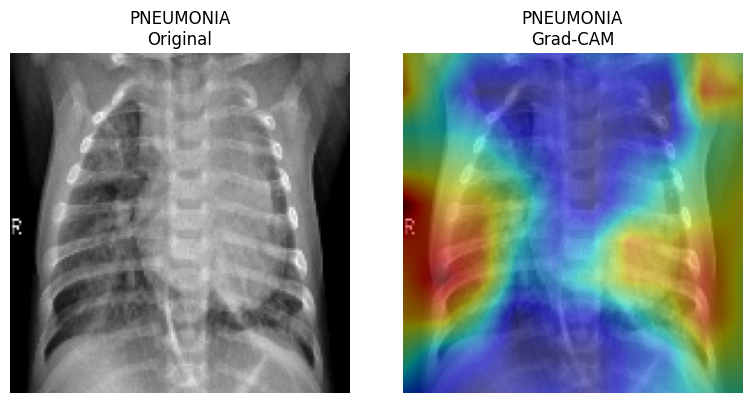

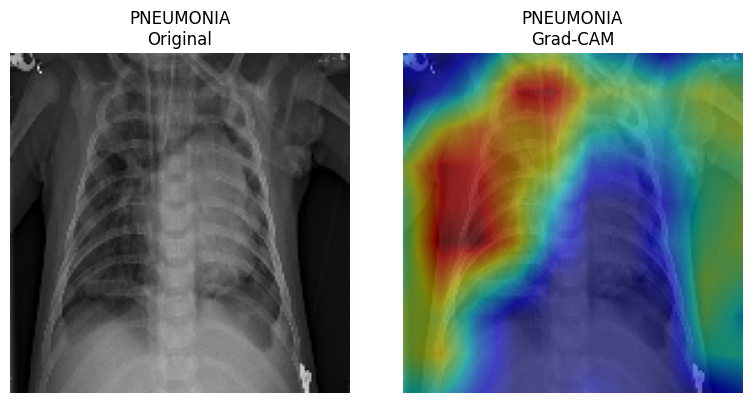

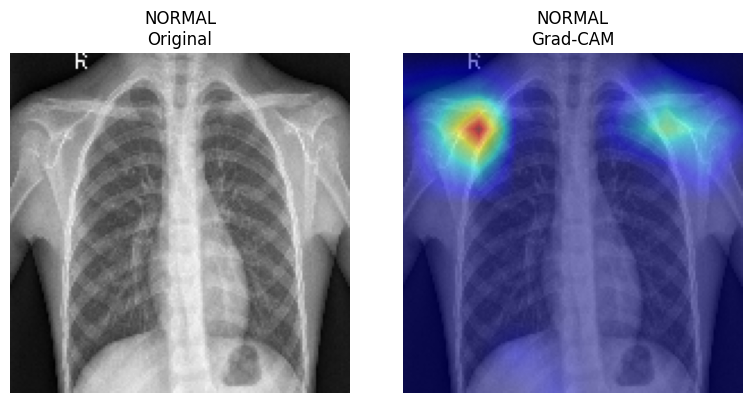

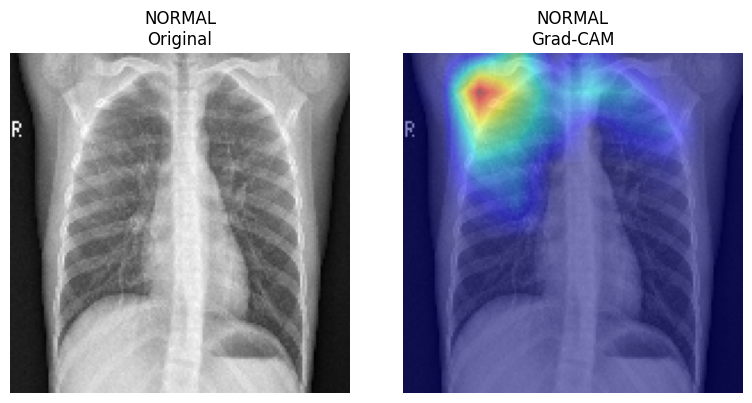

In [19]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore  # use BinaryScore for binary classification
import matplotlib.pyplot as plt
import numpy as np

# Predict once to avoid redoing it inside loop
y_probs = model.predict(X_test)
predictions = (y_probs > 0.5).astype('int32').flatten()
actuals = Y_test.flatten()

# Grad-CAM setup
model_modifier = ReplaceToLinear()
gradcam = Gradcam(model, model_modifier=model_modifier)

# Counters
normal_count = 0
pneumonia_count = 0

# Loop through test set
for i in range(len(X_test)):
    pred_label = predictions[i]
    true_label = actuals[i]

    # Only consider correctly classified images
    if pred_label == true_label:
        if true_label == 0 and pneumonia_count < 2:
            score = BinaryScore([0])  # Pneumonia class
            image = X_test[i].reshape(1, 150, 150, 1)
            cam = gradcam(score, image)[0]

            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(X_test[i].reshape(150, 150), cmap='gray')
            plt.title("PNEUMONIA\nOriginal")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(X_test[i].reshape(150, 150), cmap='gray')
            plt.imshow(cam, cmap='jet', alpha=0.5)
            plt.title("PNEUMONIA\nGrad-CAM")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            pneumonia_count += 1

        elif true_label == 1 and normal_count < 2:
            score = BinaryScore([1])  # Normal class
            image = X_test[i].reshape(1, 150, 150, 1)
            cam = gradcam(score, image)[0]

            plt.figure(figsize=(8, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(X_test[i].reshape(150, 150), cmap='gray')
            plt.title("NORMAL\nOriginal")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(X_test[i].reshape(150, 150), cmap='gray')
            plt.imshow(cam, cmap='jet', alpha=0.5)
            plt.title("NORMAL\nGrad-CAM")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            normal_count += 1

    if pneumonia_count == 2 and normal_count == 2:
        break


# Model Using Transfer Learning (ResNet50)

**Transfer Learning** is a machine learning technique where a model trained on one task is reused (or "transferred") to a different but related task.

Instead of training a deep neural network from scratch, which requires a lot of data and time,  we start with a model that has already learned useful patterns from a large dataset (like ImageNet), and adapt it to our task.

---

##  How We're Using It in Pneumonia Detection

We use **ResNet50**, a deep Convolutional Neural Network pretrained on the **ImageNet** dataset (over 14 million images across 1000 categories). Although ImageNet doesn’t contain medical images, it teaches the model to recognize universal visual features.

Here’s how we apply it :

1. **Load ResNet50 without its top layer**  
   We use `include_top=False` to remove ImageNet's classification head.

2. **Freeze the ResNet base**  
   This keeps the pretrained weights untouched during initial training.

3. **Add our own classifier**  
   We add a few custom layers for binary classification (Pneumonia vs Normal).

4. **Train only the custom head**  
   This fine-tunes the model to focus on chest X-ray features.




## Loading and Preprocessing Dataset

In [24]:
def load_data(directory):
    data = []
    labels = ['PNEUMONIA', 'NORMAL']
    image_resize_size = 150

    for label in labels:
        path = os.path.join(directory, label)
        class_num = labels.index(label)

        for img_name in os.listdir(path):
            try:
                if img_name.lower().endswith(('jpeg', 'jpg', 'png')):
                    img_path = os.path.join(path, img_name)
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (image_resize_size, image_resize_size))
                    data.append([img, class_num])
            except Exception as e:
                print(f"Error loading {img_name}: {e}")
    
    return data


# Load and shuffle data
train_data = load_data("chest_xray/train")
test_data = load_data("chest_xray/test")
val_data = load_data("chest_xray/val")

# Separate features and labels
X_train = np.array([x[0] for x in train_data]).reshape(-1, 150, 150, 1)
Y_train = np.array([x[1] for x in train_data])

X_test = np.array([x[0] for x in test_data]).reshape(-1, 150, 150, 1)
Y_test = np.array([x[1] for x in test_data])

X_val = np.array([x[0] for x in val_data]).reshape(-1, 150, 150, 1)
Y_val = np.array([x[1] for x in val_data])


In [21]:
X_train_resnet = np.repeat(X_train / 255.0, 3, axis=-1).astype('float32')
X_val_resnet   = np.repeat(X_val / 255.0, 3, axis=-1).astype('float32')
X_test_resnet  = np.repeat(X_test / 255.0, 3, axis=-1).astype('float32')


### Augmenting data

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

resnet_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)


## Training ResNet Model

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# Define the input shape (same as our resized/resnet data)
input_shape = (150, 150, 3)

# Load base ResNet50 model (pretrained on ImageNet)
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze base model layers (we’ll fine-tune later if needed)
base_model.trainable = False

# Add custom head for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # Binary output (0 or 1)

# Final model
resnet_model = Model(inputs=base_model.input, outputs=output)

# Compile
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# Summary
resnet_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [27]:
history_resnet = resnet_model.fit(
    resnet_datagen.flow(X_train_resnet, Y_train, batch_size=32),
    validation_data=(X_val_resnet, Y_val),
    epochs=10
    
)


c:\Users\Maryum\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 163s 955ms/step - accuracy: 0.7320 - loss: 0.5908 - val_accuracy: 0.5000 - val_loss: 0.7537
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 991ms/step - accuracy: 0.7451 - loss: 0.5707 - val_accuracy: 0.5000 - val_loss: 0.7624
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 132s 804ms/step - accuracy: 0.7375 - loss: 0.5655 - val_accuracy: 0.5000 - val_loss: 0.7593
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 778ms/step - accuracy: 0.7395 - loss: 0.5571 - val_accuracy: 0.5000 - val_loss: 0.7347
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 133s 818ms/step - accuracy: 0.7456 - loss: 0.5396 - val_accuracy: 0.5000 - val_loss: 0.7030
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 663ms/step - accuracy: 0.7466 - loss: 0.5348 - val_accuracy: 0.5000 - val_loss: 0.7485
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 737ms/step - accuracy: 0.7452 - loss: 0.5239 - val_accuracy: 0.5000 - val_loss: 0.7196
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 786ms/step - accuracy: 0.7474 -

In [28]:
resnet_model.save("resnet_pneumonia_model.keras")

## Performance Evaluation

20/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
Confusion Matrix:
 [[375  15]
 [173  61]]


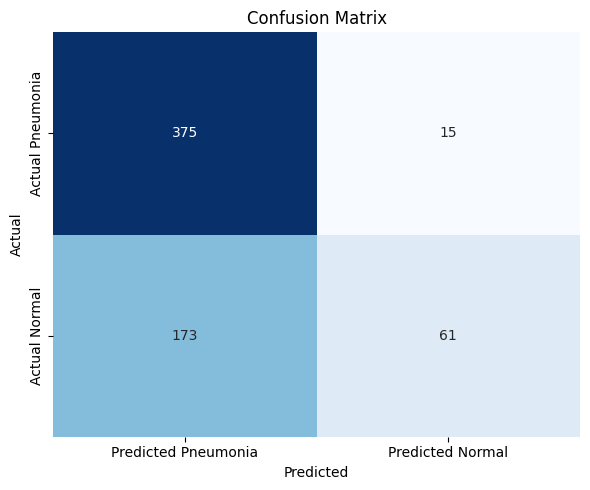

Classification Report:

              precision    recall  f1-score   support

   PNEUMONIA       0.68      0.96      0.80       390
      NORMAL       0.80      0.26      0.39       234

    accuracy                           0.70       624
   macro avg       0.74      0.61      0.60       624
weighted avg       0.73      0.70      0.65       624

Accuracy: 69.87179487179486


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_probs = resnet_model.predict(X_test_resnet)
predictions = (y_probs > 0.5).astype('int32').flatten()

# Confusion matrix
c_matrix = confusion_matrix(Y_test, predictions)
print("Confusion Matrix:\n", c_matrix)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Pneumonia', 'Predicted Normal'],
            yticklabels=['Actual Pneumonia', 'Actual Normal'])


plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(Y_test, predictions, target_names=["PNEUMONIA", "NORMAL"]))

# Accuracy
acc = accuracy_score(Y_test, predictions)
print(f"Accuracy: {acc*100}")


## Interpretability (Grad CAM)

20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 957ms/step


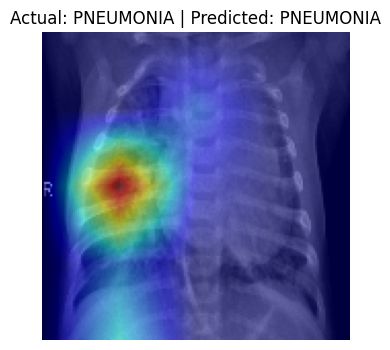

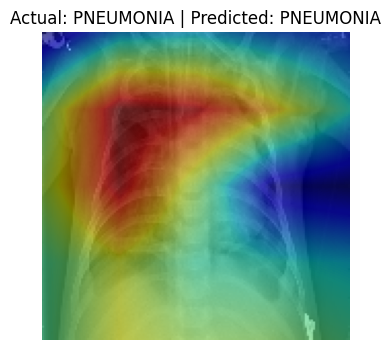

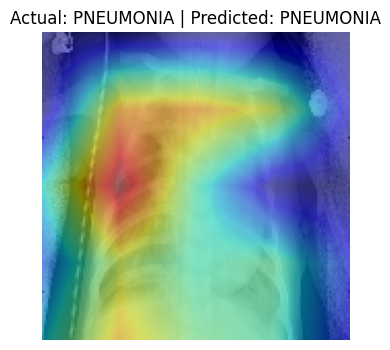

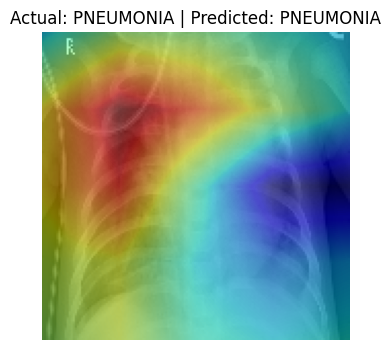

In [33]:
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import matplotlib.pyplot as plt
import numpy as np

#  Define score function: 0 = PNEUMONIA, 1 = NORMAL
score = CategoricalScore([0])  # or [1] to see Grad-CAM for NORMAL

#  Replace softmax/sigmoid with linear activation in last layer
model_modifier = ReplaceToLinear()

# Create GradCAM object
gradcam = Gradcam(resnet_model, model_modifier=model_modifier)

#  Predict to find correct predictions
preds = resnet_model.predict(X_test_resnet)
pred_labels = (preds > 0.5).astype('int').flatten()
correct_indices = np.where(pred_labels == Y_test)[0]

#  Loop over a few correct predictions
for i, idx in enumerate(correct_indices[:4]):
    input_image = X_test_resnet[idx].reshape(1, 150, 150, 3)

    cam = gradcam(score, input_image)[0]

    # Plot original image with Grad-CAM overlay
    plt.figure(figsize=(4, 4))
    plt.imshow(X_test_resnet[idx])
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    actual = "PNEUMONIA" if Y_test[idx] == 0 else "NORMAL"
    predicted = "PNEUMONIA" if pred_labels[idx] == 0 else "NORMAL"
    plt.title(f"Actual: {actual} | Predicted: {predicted}")
    plt.show()
